# Waste_Assist Sorting

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

In [ ]:
!gsutil -m cp -r "gs://waste-assist-batch665/data" .

Copying gs://waste-assist-batch665/data/test/cardboard/IMG_8367.jpeg...
Copying gs://waste-assist-batch665/data/test/cardboard/IMG_8376.jpeg...
Copying gs://waste-assist-batch665/data/test/cardboard/IMG_8505.jpeg...
Copying gs://waste-assist-batch665/data/test/cardboard/IMG_8422.jpeg...
Copying gs://waste-assist-batch665/data/test/cardboard/IMG_8427.jpeg...
Copying gs://waste-assist-batch665/data/test/cardboard/IMG_8429.jpeg...
Copying gs://waste-assist-batch665/data/test/cardboard/IMG_8444.jpeg...
Copying gs://waste-assist-batch665/data/test/cardboard/IMG_8448.jpeg...
Copying gs://waste-assist-batch665/data/test/cardboard/IMG_8489.jpeg...
Copying gs://waste-assist-batch665/data/test/cardboard/IMG_8501.jpeg...
Copying gs://waste-assist-batch665/data/test/cardboard/IMG_8507.jpeg...
Copying gs://waste-assist-batch665/data/test/cardboard/cardboard108.jpg...
Copying gs://waste-assist-batch665/data/test/cardboard/cardboard114.jpg...
Copying gs://waste-assist-batch665/data/test/cardboard/car

# Preprocessing the Training & Val set


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range=20,
                                   vertical_flip = True,
                                   horizontal_flip = True,
                                    validation_split=0.1)

drive_dir = '/content/drive/MyDrive/waste_assist'
local_dir = './data'

X_train = train_datagen.flow_from_directory(
                                        f'{local_dir}/train',
                                        target_size = (256, 256),
                                        batch_size = 32,
                                        class_mode = 'categorical',
                                        subset = 'training')

Found 2162 images belonging to 7 classes.


In [ ]:
X_val = train_datagen.flow_from_directory(
        f'{local_dir}/train',
        target_size=(256, 256),
        batch_size=8,
        class_mode='categorical',
        subset = 'validation')

Found 236 images belonging to 7 classes.


In [ ]:
X_train.class_indices

{'cardboard': 0,
 'compost': 1,
 'glass': 2,
 'metal': 3,
 'paper': 4,
 'plastic': 5,
 'trash': 6}

# Preprocessing the Test set

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
X_test = test_datagen.flow_from_directory(f'{drive_dir}/test',
                                            target_size = (256, 256),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 73 images belonging to 7 classes.


## Visualizing the Batches

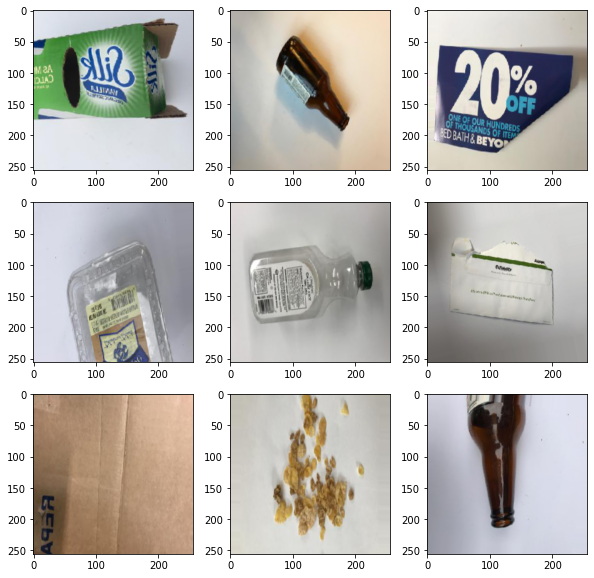

In [ ]:
plt.figure(figsize=(10,10))
X_train.reset()
# generate batch of images
batch  = X_train.next()
# generate samples and plot
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(batch[0][i])
# show the figure
plt.show()

## Load VGG16 model

In [ ]:
from keras.applications.vgg16 import VGG16

def load_model():

    model = VGG16(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
    print(model.summary())
    return model

In [ ]:
model = load_model()
model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
______________________________________________________________

In [ ]:
def set_nontrainable_layers(model):
    # Set the first layers to be untrainable
    
    model.trainable = False
  
    return model

model = set_nontrainable_layers(model)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

## Adding additional trainable layers on the pre-trained model

In [ ]:
from tensorflow.keras import layers, models

def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainables, and add additional trainable layers on top'''

    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(500, activation='relu')
    prediction_layer = layers.Dense(7, activation='softmax')

    model = models.Sequential([
                  base_model,
                  flatten_layer,
                  dense_layer, 
                  prediction_layer
    ])

    return model

In [ ]:
model = add_last_layers(model)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 500)               16384500  
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 3507      
Total params: 31,102,695
Trainable params: 16,388,007
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay

def build_model():

    model = load_model()
    model = add_last_layers(model)

    initial_learning_rate = 0.01
    lr_schedule = ExponentialDecay(
        initial_learning_rate, decay_steps=2000, decay_rate=0.5) 
        # Every 2000 iterations, multiply the learning rate by 0.5
        

    adam_opt = optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='categorical_crossentropy', 
                  optimizer=adam_opt,
                  metrics=['accuracy'])

    return model

In [ ]:
model = build_model()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(patience=20, verbose=1, restore_best_weights=True, monitor='val_accuracy')

In [ ]:
import os

checkpoint_path = f"{drive_dir}/vgg16/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True, 
                                                 verbose=1, monitor= 'val_accuracy',
                                                save_best_only=True, mode='max', 
                                                )


In [ ]:
history = model.fit(X_train, 
                   validation_data=X_val, 
                   callbacks=[cp_callback, es],
                    epochs=100, 
                    batch_size=32, 
                    use_multiprocessing=True,
                    workers = 10)

Epoch 1/100
68/68 [==============================] - 128s 1s/step - loss: 21.2389 - accuracy: 0.3696 - val_loss: 1.5117 - val_accuracy: 0.4619

Epoch 00001: val_accuracy improved from -inf to 0.46186, saving model to /content/drive/MyDrive/waste_assist/vgg16/cp.ckpt
Epoch 2/100
68/68 [==============================] - 89s 1s/step - loss: 1.1531 - accuracy: 0.5957 - val_loss: 1.4556 - val_accuracy: 0.4746

Epoch 00002: val_accuracy improved from 0.46186 to 0.47458, saving model to /content/drive/MyDrive/waste_assist/vgg16/cp.ckpt
Epoch 3/100
68/68 [==============================] - 82s 1s/step - loss: 0.9018 - accuracy: 0.6832 - val_loss: 1.0608 - val_accuracy: 0.6229

Epoch 00003: val_accuracy improved from 0.47458 to 0.62288, saving model to /content/drive/MyDrive/waste_assist/vgg16/cp.ckpt
Epoch 4/100
68/68 [==============================] - 90s 1s/step - loss: 0.7678 - accuracy: 0.7313 - val_loss: 1.0920 - val_accuracy: 0.6271

Epoch 00004: val_accuracy improved from 0.62288 to 0.62

In [ ]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

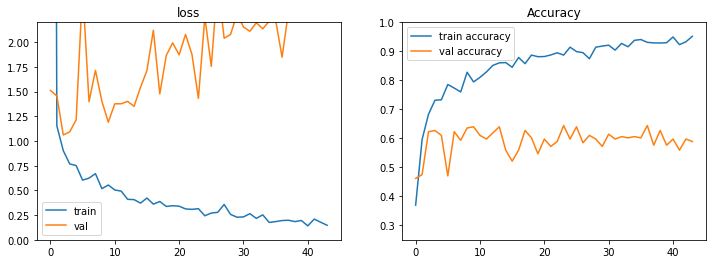

In [ ]:
plot_history(history)
plt.show()

# Model Evaluation

In [ ]:
model.evaluate(x=X_test)

3/3 [==============================] - 22s 11s/step - loss: 0.4047 - accuracy: 0.8767


[0.40474438667297363, 0.8767123222351074]

# Load and Prepare Image

In [ ]:
# # load an image from file
# image = load_img(f'{drive_dir}/single_prediction/cardboard_image.jpg', target_size=(256, 256))

# # convert the image pixels to a numpy array
# image = img_to_array(image)

# # reshape data for the model
# image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

# # prepare the image for the VGG model
# image = preprocess_input(image)

## Make a Single Prediction

In [ ]:
from keras.preprocessing import image
test_image = image.load_img(f'{drive_dir}/single_prediction/metal_image.jpg', target_size = (256, 256))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(result)
X_train.class_indices

[[0. 0. 0. 1. 0. 0. 0.]]


{'cardboard': 0,
 'compost': 1,
 'glass': 2,
 'metal': 3,
 'paper': 4,
 'plastic': 5,
 'trash': 6}

## Interpret Prediction

In [ ]:
def prediction():
    for key, value in X_train.class_indices.items():
        if result[0][value] == 1:
            return key
prediction()

'metal'